<a href="https://colab.research.google.com/github/up99/golf-sintez/blob/main/Media_Pipe_Pose_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Install and Import Dependencies

In [1]:
!pip install mediapipe opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 28.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

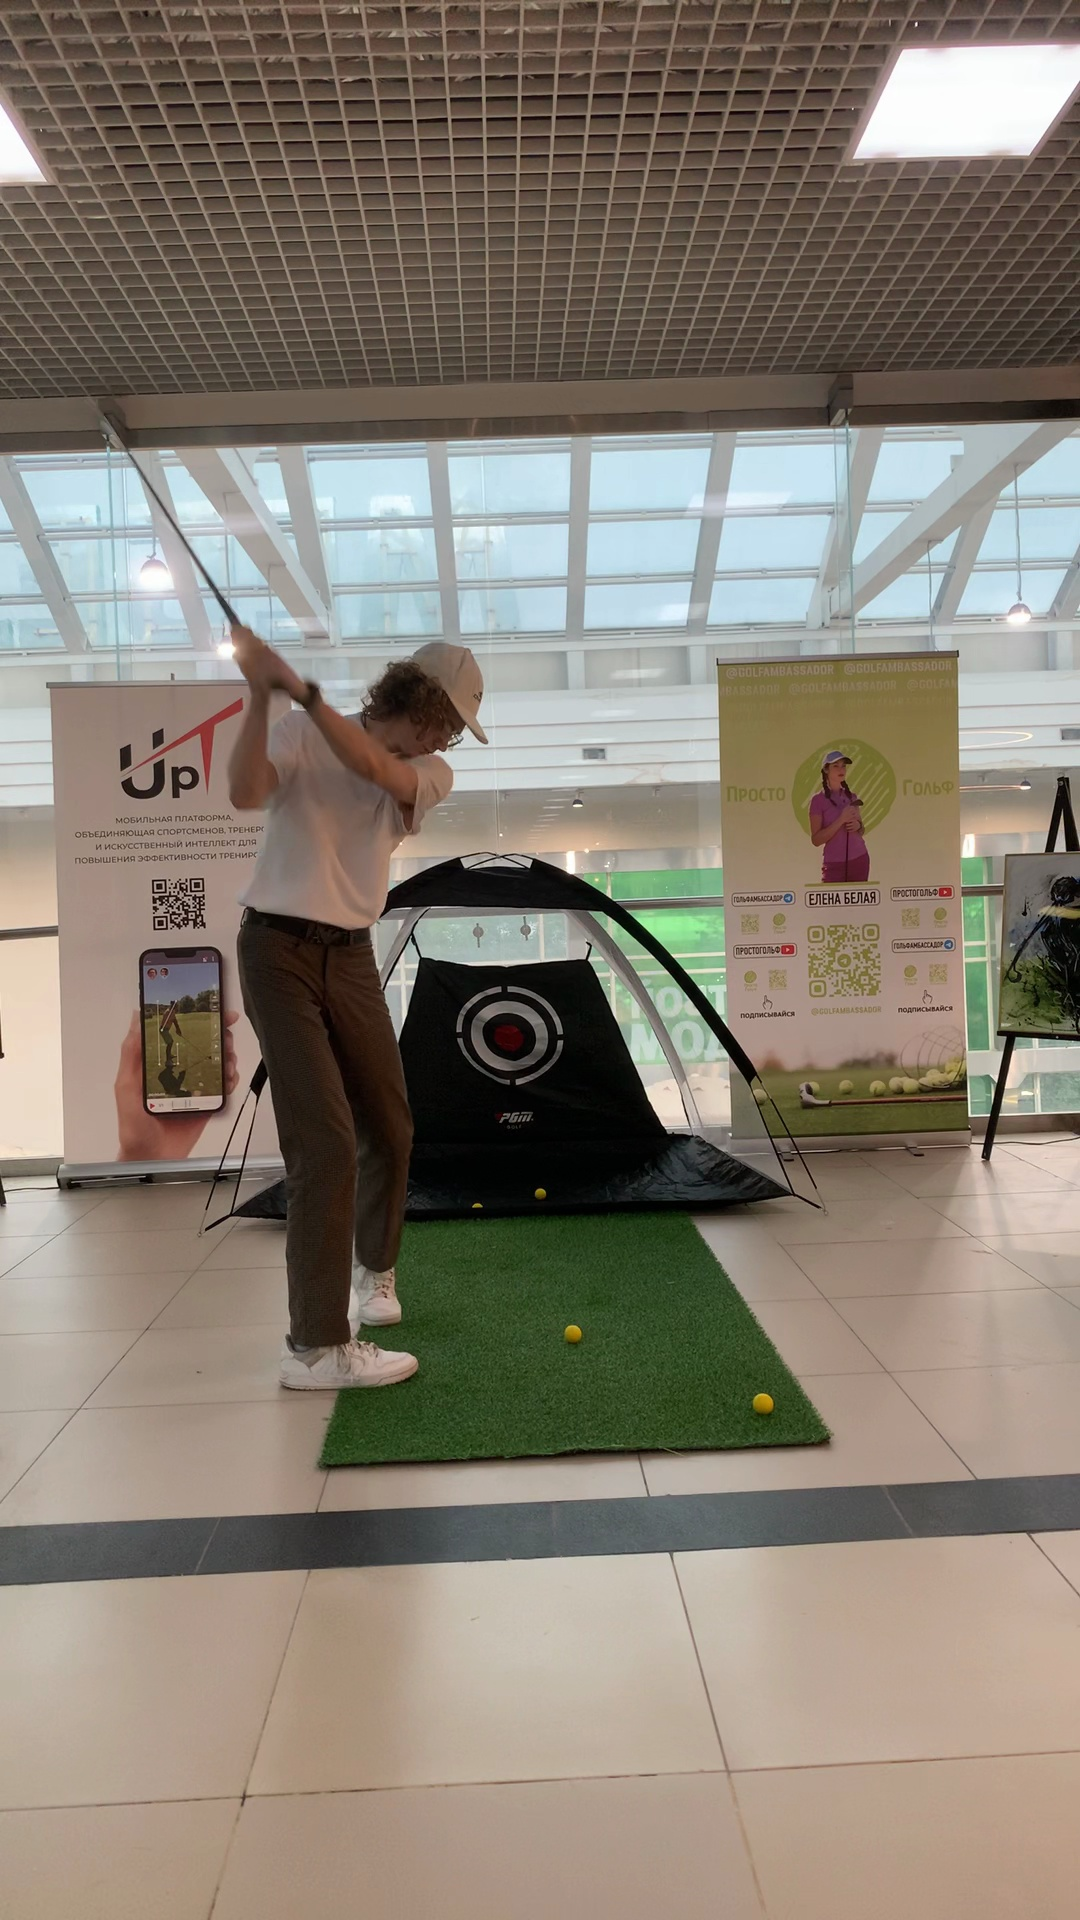

In [4]:
frame = cv2.imread("/content/drive/MyDrive/цифровой_прорыв/0ae17d29-242b-40ec-bff6-fe6b23ac8824_frame_19.jpg")
cv2_imshow(frame)
cv2.destroyAllWindows()

<img src="https://i.imgur.com/3j8BPdc.png" style="height:300px" >

# 2. Calculate Angles

shoulders,
 elbows, wrists, hips, knees, ankles, heels, foot indexes, ears and mouth

address :
180deg - hip-knee-ankle  = (20,25) deg
180deg - knee-hip-shoullder = 45 deg

mistake

Lead side lateral bending

head movement : for P1 Address P4 Top  eye_outer, ear, mouth should be the same

In [10]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    if angle >180.0:
        angle = 360-angle
    return angle

In [11]:
def analyse_view(heel_l, heel_r, foot_ind_l, foot_ind_r, eps):
  if (foot_ind_l[0]>heel_l[0]+eps and foot_ind_r[0]>heel_r[0]+eps):
    print("right down the line")
    return "right"
  else:
    if (foot_ind_l[0]<heel_l[0] - eps and foot_ind_r[0]<heel_r[0] - eps):
      print("left down the line")
      return"left"
    else:
      print("face on view \n")
      return "face on view"



In [25]:
def address_mistake(eps,shoulder, hip, knee, ankle):#to fix
  alpha = 180 - calculate_angle(hip, knee, ankle)
  beta = 180 - calculate_angle(knee, hip, shoulder)
  if alpha < (20 - eps) or alpha>(25 + eps):
    print("addess is incorrect with knee, alpha is ", alpha, "\n")
  else:
    print("no address knee angle mistake")
  if beta <(45 - eps) or beta> (45 + eps):
    print("address incorrect spine angle, beta is ", beta, "\n")
  else:
    print("no address spine angle mistake")


In [26]:
def head_mov_mistake(ear_P1,  mouth_P1, ear_P4, mouth_P4, eps):
  if (ear_P1[0] < (ear_P4[0]- eps) or ear_P1[0] >(ear_P4[0] + eps) or mouth_P1[0] <(mouth_P4[0]- eps) or mouth_P1[0] > (mouth_P4[0] + eps) or ear_P1[1] < (ear_P4[1]- eps) or ear_P1[1] > (ear_P4[1] + eps) or mouth_P1[1] < (mouth_P4[1]- eps) or mouth_P1[1] > (mouth_P4[1] + eps)):
     print("head movement mistake\n")


example on image

right down the lite


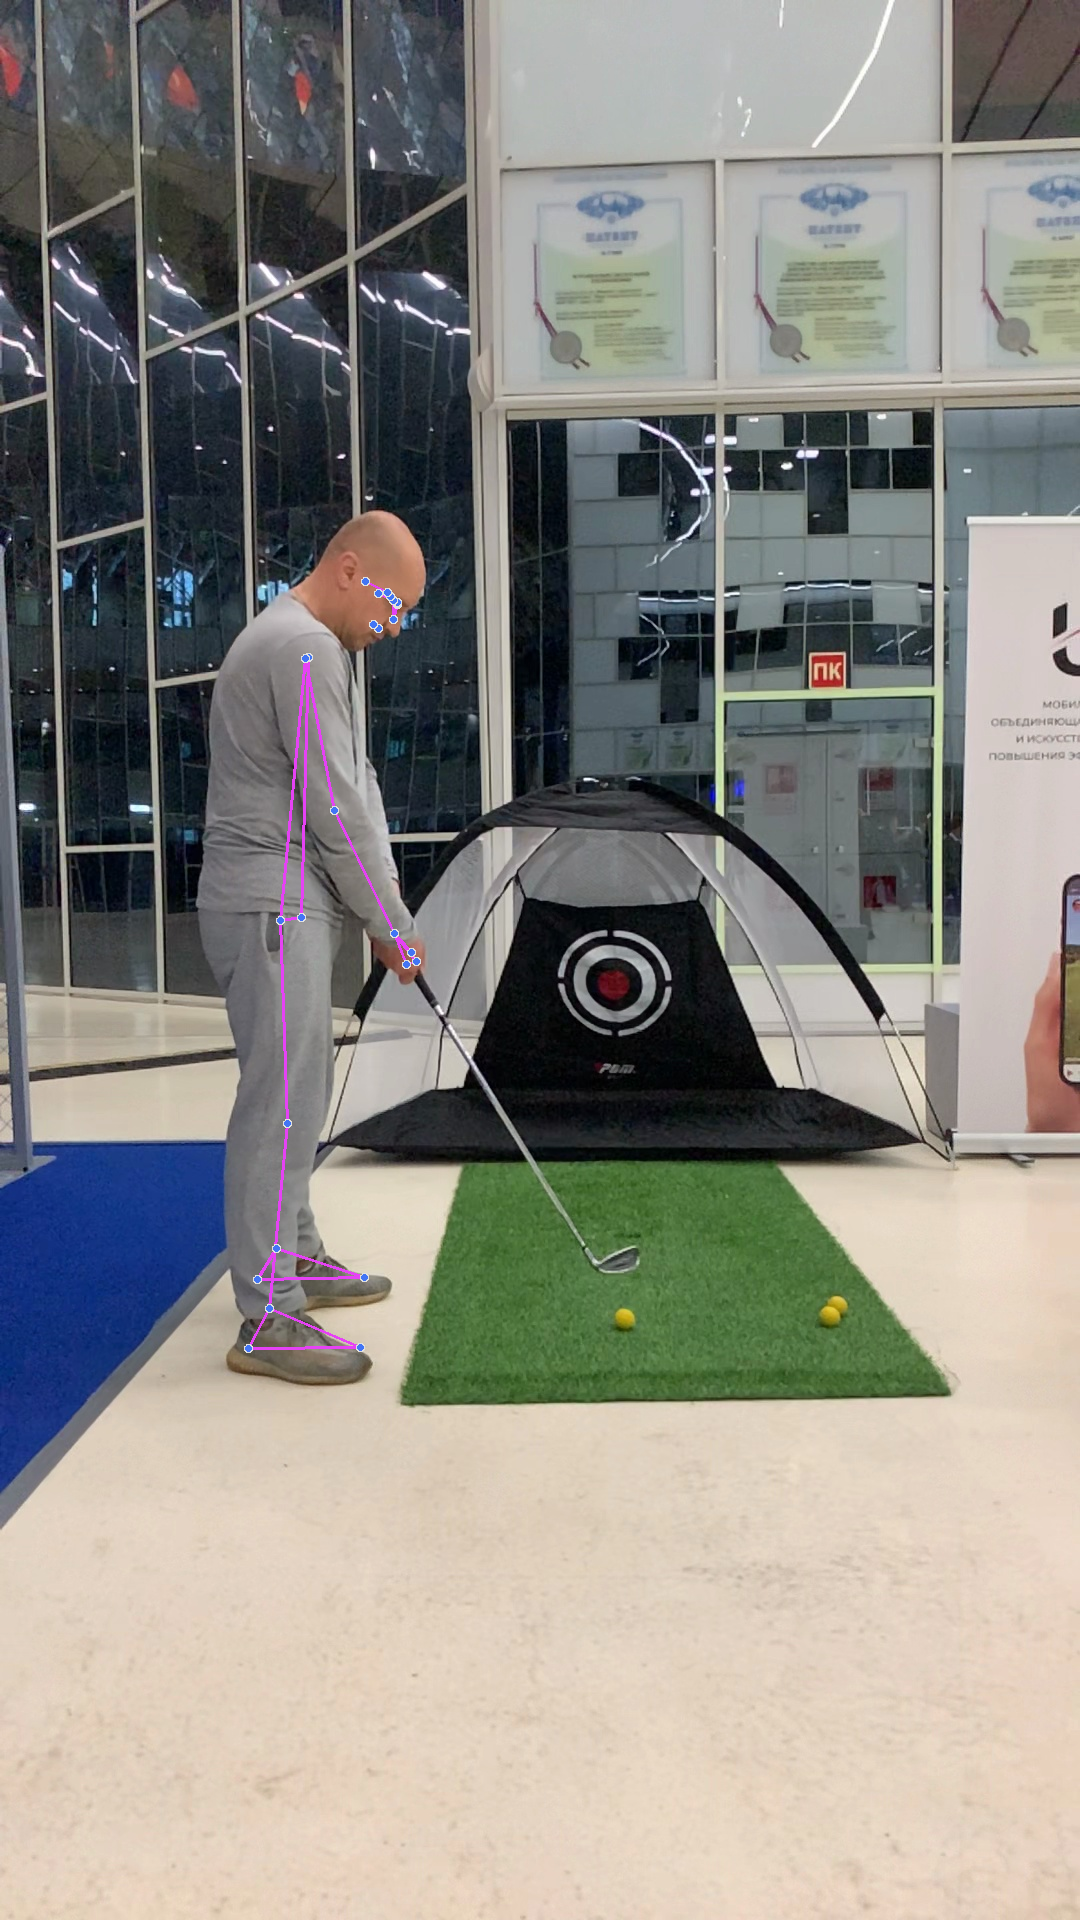

In [27]:

## Setup mediapipe instance
ear_P1,  mouth_P1, ear_P4, mouth_P4 = [0,0], [0,0], [0,0], [0,0]

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
#загружаем кадр из видео
      frame = cv2.imread("/content/drive/MyDrive/цифровой_прорыв/5aa19ed0-c288-4048-8654-66e5437f5f48_frame_145.jpg")
#получаем фазу свинга из классификатора
      stage = "address"
      # Recolor image to RGB
      image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      image.flags.writeable = False

      # Make detection
      results = pose.process(image)

      # Recolor back to BGR
      image.flags.writeable = True
      image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
#получаем ключевые точки из MoveNet
      landmarks = results.pose_landmarks.landmark

      heel_l =  [landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].y]
      foot_ind_l =  [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value].x,landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value].y]
      heel_r =  [landmarks[mp_pose.PoseLandmark.RIGHT_HEEL.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HEEL.value].y]
      foot_ind_r =  [landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].y]
      #вычисляем ракурс
      eps = 0
      view = analyse_view(heel_l, heel_r, foot_ind_l, foot_ind_r, eps)

# запоминаем нужные значения для вычисления ошибки head movement
      if stage =="address" and (view == "right" or view == "left"):
        try:
          ear_P1 =  [landmarks[mp_pose.PoseLandmark.LEFT_EAR.value].x,landmarks[mp_pose.PoseLandmark.LEFT_EAR.value].y]
          mouth_P1 = [landmarks[mp_pose.PoseLandmark.MOUTH_LEFT.value].x,landmarks[mp_pose.PoseLandmark.LEFT_MOUTH_LEFT.value].y]
        except:
          ear_P1 =  [landmarks[mp_pose.PoseLandmark.RIGHT_EAR.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_EAR.value].y]
          mouth_P1 = [landmarks[mp_pose.PoseLandmark.MOUTH_RIGHT.value].x,landmarks[mp_pose.PoseLandmark.MOUTH_RIGHT.value].y]
        eps = 10
        shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
        knee =  [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
        ankle =  [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
        # вычисляем углы в первой фазе и определяем наличие ошибки
        address_mistake(eps ,shoulder, hip, knee, ankle)

      stage = "top"
      if stage =="top":
        try:
          ear_P4 =  [landmarks[mp_pose.PoseLandmark.LEFT_EAR.value].x,landmarks[mp_pose.PoseLandmark.LEFT_EAR.value].y]
          mouth_P4 = [landmarks[mp_pose.PoseLandmark.MOUTH_LEFT.value].x,landmarks[mp_pose.PoseLandmark.MOUTH_LEFT.value].y]
        except:
          ear_P4 =  [landmarks[mp_pose.PoseLandmark.RIGHT_EAR.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_EAR.value].y]
          mouth_P4 = [landmarks[mp_pose.PoseLandmark.MOUTH_RIGHT.value].x,landmarks[mp_pose.PoseLandmark.MOUTH_RIGHT.value].y]
# вычисляем ошибку head movement
      #head_mov_mistake(ear_P1,  mouth_P1, ear_P4, mouth_P4, eps)


      # Render detections
      mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                )
      cv2_imshow(image)
      cv2.destroyAllWindows()
